In [1]:
import os
parent_dir = os.path.dirname(os.getcwd())
print(parent_dir)  # Prints parent directory
os.chdir(parent_dir)
#print(os.getcwd())  # Prints current working directory
import mmars

c:\Users\malth\OneDrive - Aarhus Universitet\Dokumenter\AAU-Studie\10. semester\NEW GIT\MMARS


In [2]:
import numpy as np
from scipy.constants import c, Boltzmann
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy import signal

import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed

# MRBLaT testing

In [3]:
radar_model_1 = mmars.FmcwRadar(position=np.array([[0,0]]), signalNoiseRatio=[2000, 10])

[[-0.02336045  0.        ]
 [-0.01557363  0.        ]
 [-0.00778682  0.        ]]
[[-0.00292006  0.        ]
 [-0.00097335  0.        ]
 [ 0.00097335  0.        ]
 [ 0.00292006  0.        ]]


In [4]:
target_model_1 = mmars.Target(start_position=np.array([[5.001,5.001]]), start_velocity=5., T_total=10., T_frame=0.1)

target_model_1.generate_trajectory(trajectory_type="sinusoidal")

target_ground_truth = target_model_1.get_trajectory()

In [5]:
simulation_data = mmars.Simulation(radar_model_1, target_model_1)

simulation_data.run()

Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x0000017A2A183490> and <mmars.target.Target object at 0x0000017A6A4136D0>


100%|██████████| 100/100 [00:06<00:00, 14.82it/s]


In [6]:
sim_data = simulation_data.get_data()
lambda_z_coefficient = radar_model_1.get_standardDeviation()
lambda_z_coefficient

np.float64(8.740075449196408e-107)

In [7]:
sim_data_snrs = simulation_data.get_SNR()

In [8]:
radial_distances = np.zeros(len(target_ground_truth[0]))

for i in range(len(target_ground_truth[0])):
    radial_distances[i] = np.sqrt(target_ground_truth[0][i]**2 + target_ground_truth[1][i]**2)

In [28]:
wavelength = c/77e9

def generate_S_signal(
                    target_x, 
                    target_y, 
                    position=np.array([[0,0]]),
                    tx_antennas = np.array(([-12*(wavelength/2), 0],
                                           [-8*(wavelength/2), 0],
                                           [-4*(wavelength/2), 0])),
                    rx_antennas = np.array(([-(3/2)*(wavelength/2), 0],
                                    [-(1/2)*(wavelength/2), 0],
                                    [(1/2)*(wavelength/2), 0],
                                    [(3/2)*(wavelength/2), 0])),
                    chirp_Rate = 30e6/1e-6, 
                    T_chirp = 25.66e-6,
                    transmitPower = 1,
                    gain = 1,
                    radarCrossSection = 1,
                    f_sampling = 20e6,
                    N_samples = 256,
                    N_chirps = 1,
                    wavelength = c/77e9
                    ):
        
    S_signal = np.zeros((tx_antennas.shape[0], rx_antennas.shape[0], N_chirps, N_samples),dtype=complex)
    target_position = np.array([target_x, target_y])

    # Compute the radial distance to the target
    radial_distance = np.linalg.norm(position - target_position, axis=1)


    # Compute all distances between TX and RX antennas and the target
    distances = np.zeros((len(tx_antennas), len(rx_antennas)))
    for tx_idx in range(len(tx_antennas)):
        for rx_idx in range(len(rx_antennas)):
            distances[tx_idx,rx_idx] = np.linalg.norm(tx_antennas[tx_idx] - target_position) + np.linalg.norm(rx_antennas[rx_idx] - target_position)

    # Compute the phase difference between the antennas
    phase_diff_TX_RX = 2*np.pi*distances/wavelength
    phase_diff_TX_RX -= phase_diff_TX_RX[0,0]

    # Compute the Intermediate frequency (IF) frequency:
    sweepBandwidth = chirp_Rate*T_chirp
    f_IF = (2*radial_distance*sweepBandwidth)/(c*T_chirp) 

    # Compute the received power:
    received_power = transmitPower*gain*wavelength**2*radarCrossSection/( (4*np.pi)**3 * radial_distance**4)
    
    # Generate the IF signal
    freqs = np.linspace(0,2 * np.pi, N_samples)[np.newaxis]  # Time variable running from 0 to N_samples/F_sampling
    #time = np.linspace(0, N_samples/f_sampling, N_samples)[np.newaxis]
    for tx_idx in range(tx_antennas.shape[0]):
        for rx_idx in range(rx_antennas.shape[0]):

            S_signal[tx_idx, rx_idx, :, :] =  (np.exp(-1.j * freqs * N_samples/2) * np.sin((freqs - f_IF /f_sampling * 2 * np.pi) * (N_samples + 1) * 1/2) / np.sin((freqs - f_IF/f_sampling * 2 * np.pi)/2)
                                              )*np.exp(1j*phase_diff_TX_RX[tx_idx,rx_idx])
                                                        
    S_signal *= np.sqrt(received_power) # Scale the signal based on the received power

    return S_signal.flatten()[:, np.newaxis]#/np.sqrt(256)

In [10]:
Lambda_z = np.eye(3072) * (lambda_z_coefficient)
lambda_z = csr_matrix(Lambda_z)

def alpha_hat(phi_mu_x, phi_mu_y, data_fourier):
    s_nn = generate_S_signal(phi_mu_x, phi_mu_y)
    
    # Compute conjugate transpose once
    s_nn_H = s_nn.conj().T  # Conjugate transpose
    
    return (s_nn_H @ lambda_z @ data_fourier) / (s_nn_H @ lambda_z @ s_nn)

In [11]:
def jacobian_S(epsilon,
                        position = np.array([0, 0]),
                        tx_antennas = None, rx_antennas = None,
                        S=30e6/1e-6,T_chirp=25.66e-6, transmitPower=1, gain=1, radarCrossSection=1,
                        f_sampling=20e6, N_samples=256, N_chirps=1, c = 299792458, start_freq = 77e9):
    
    wavelength = c/start_freq
    if tx_antennas is None:
        tx_antennas = np.array(([-12*(wavelength/2), 0],
                                [-8*(wavelength/2), 0],
                                [-4*(wavelength/2), 0]))
    if rx_antennas is None:
        rx_antennas = np.array(([-(3/2)*(wavelength/2), 0],
                                [-(1/2)*(wavelength/2), 0],
                                [(1/2)*(wavelength/2), 0],
                                [(3/2)*(wavelength/2), 0]))
        
    N_vx_antennas = len(tx_antennas) * len(rx_antennas)
    x, y = epsilon
    x_r, y_r = position

    ## related to path loss
    A = np.sqrt(transmitPower * gain * radarCrossSection * wavelength**2 / (4 * np.pi)**3)

    ## related to steering matrix
    ds = np.arange(0, N_vx_antennas * wavelength/2, wavelength/2)

    ## related to sinc fnc
    freqs = np.linspace(0, 2 * np.pi, N_samples)[np.newaxis]

    def path_loss(x, y):
        """path loss"""
        r = np.sqrt((x - x_r)**2 + (y - y_r)**2)
        alpha = A/r**2
        return alpha

    def partial_path_loss(x, y, x__R, y__R):
        """path loss alpha partial differentiated w.r.t first entry (works for x/y)"""
        r = np.sqrt((x - x__R)**2 + (y - y__R)**2)
        partial_alpha = - 2 * A * r**(-4) * (x - x__R)
        return partial_alpha

    def steering_matrix(x, y):
        """steering matrix"""
        deltaR = np.sin(-np.atan2(x - x_r, y - y_r)) * ds
        phi = 2 * np.pi * deltaR / wavelength
        steering_mat = np.exp(1.j * 2 * np.pi * phi)
        return steering_mat[:, np.newaxis]

    def partial_steering_matrix(x, y, x__R, y__R, x_partial=True):
        """steering matrix partial differentiated w.r.t x/y"""
        exp1 = 1 + (x - x__R)**2/(y - y__R)**2
        partial_deltaR = (-(1/((y - y__R) * np.sqrt(exp1))) + (x - x__R)**2/((y - y__R)**3 * exp1**(3/2))) * ds
        
        if not x_partial:
            partial_deltaR = ((x - x__R)/((y - y__R)**2 * np.sqrt(exp1)) - ((x - x__R)**3/((y - y__R)**4 * exp1**(3/2)))) * ds

        partial_phi_deltaR = 2 * np.pi/wavelength

        deltaR = np.sin(-np.atan2(x, y)) * ds
        phi = 2 * np.pi * deltaR / wavelength
        partial_a_phi = 1.j * 2 * np.pi * np.exp(1.j * 2 * np.pi * phi)
        partial_steering_mat = partial_a_phi * partial_phi_deltaR * partial_deltaR
        return partial_steering_mat[:, np.newaxis]
        
    def sinc(x, y):
        """sinc function"""
        r = np.sqrt((x - x_r)**2 + (y - y_r)**2)
        f_IF = 2 * S * r / c * (2 * np.pi / f_sampling)
        K = np.exp(-1.j * freqs * N_samples/2)

        sinc_fnc = K * np.sin((freqs - f_IF) * (N_samples + 1) * 1/2)/np.sin((freqs - f_IF)/2)
        return sinc_fnc
    
    def partial_sinc(x, y, x__R, y__R):
        """sinc fnc (fourier transform of window fnc) partially differentiated w.r.t. first entry"""
        K = np.exp(-1.j * freqs * N_samples/2)
        f = freqs
        N__s = N_samples

        # from Maple:
        partial_sinc = (K * S * ((x - x__R) ** 2 + (y - y__R) ** 2) ** (-0.1e1 / 0.2e1) / c * np.pi * (2 * x - 2 * x__R) * (N__s + 1) 
                        * np.cos((f - S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c * np.pi / 5000000) * (N__s + 1) / 2) 
                        / np.sin(-f / 2 + S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c * np.pi / 10000000) / 20000000 + K 
                        * np.sin((f - S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c * np.pi / 5000000) * (N__s + 1) / 2) 
                        / np.sin(-f / 2 + S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c * np.pi / 10000000) ** 2 * S 
                        * ((x - x__R) ** 2 + (y - y__R) ** 2) ** (-0.1e1 / 0.2e1) / c * np.pi * (2 * x - 2 * x__R) 
                        * np.cos(-f / 2 + S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c * np.pi / 10000000) / 20000000
                        )
        return partial_sinc

    S_tilde = steering_matrix(x, y) @ sinc(x, y)
    partial_S_tilde_x = partial_steering_matrix(x, y, x_r, y_r, x_partial=True) @ sinc(x, y) + steering_matrix(x, y) @ partial_sinc(x, y, x_r, y_r)
    S_jacobian_x = np.reshape(partial_S_tilde_x * path_loss(x, y) + S_tilde * partial_path_loss(x, y, x_r, y_r), [N_vx_antennas * N_samples])[:, np.newaxis]

    partial_S_tilde_y = partial_steering_matrix(x, y, x_r, y_r, x_partial=False) @ sinc(x, y) + steering_matrix(x, y) @ partial_sinc(y, x, y_r, x_r)
    S_jacobian_y = np.reshape(partial_S_tilde_y * path_loss(x, y) + S_tilde * partial_path_loss(y, x, y_r, x_r), [N_vx_antennas * N_samples])[:, np.newaxis]

    S_jacobian = np.hstack((S_jacobian_x, S_jacobian_y))
    return S_jacobian

In [12]:
#Lambda_z = np.eye(3072) * (Boltzmann * 290 * 0.77e9)**(-2)
Lambda_z = np.eye(3072) * (lambda_z_coefficient)**(-2)
Lambda_z = csr_matrix(Lambda_z)

def D_KL(params, Z_data, phi_bar_last_x, phi_bar_last_y):
    eps_bar_x, eps_bar_y, eps_barbar_0, eps_barbar_1 = params

    alpha_hat_xy = alpha_hat(phi_bar_last_x, phi_bar_last_y, Z_data)
    
    s_n = generate_S_signal(eps_bar_x, eps_bar_y)

    term_1 = -np.abs(alpha_hat_xy * (s_n.conj().T @ Lambda_z @ Z_data))
    term_2 = np.real(np.abs(alpha_hat_xy)**2 * s_n.conj().T @ Lambda_z @ s_n)
    
    jac = jacobian_S(np.array([eps_bar_x, eps_bar_y]))
    term_3_inner_prod = np.real(jac.conj().T @ Lambda_z @ jac)
    
    term_3 = np.abs(alpha_hat_xy)**2 * np.trace(np.array([[eps_barbar_0, 0], [0, eps_barbar_1]]) * term_3_inner_prod)
    k = 2
    entropy = k/2 * np.log(2*np.pi*np.e) + 1/2*np.log(eps_barbar_0 * eps_barbar_1)
    
    return term_3

In [13]:
term_3_data = np.zeros(len(target_ground_truth[0]))

for i in range(99):

    sim_data_all_virtual = sim_data[i+1,:,:,0,:]
    sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

    # Energy normalization
    sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

    data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[k:k+256, 0]) for k in range(0, len(sim_data_all_virtual), 256)])

    data_fourier_energy = data_fourier.conj().T @ data_fourier

    data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T
    
    param = np.array([target_ground_truth[0][i], target_ground_truth[1][i], 1, 1])
    phi_bar_last_x = target_ground_truth[0][i]
    phi_bar_last_y = target_ground_truth[1][i]

    term_3_data[i] = D_KL(param, data_fourier, phi_bar_last_x, phi_bar_last_y)

C:\Users\malth\AppData\Local\Temp\ipykernel_30232\4198177611.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  term_3_data[i] = D_KL(param, data_fourier, phi_bar_last_x, phi_bar_last_y)


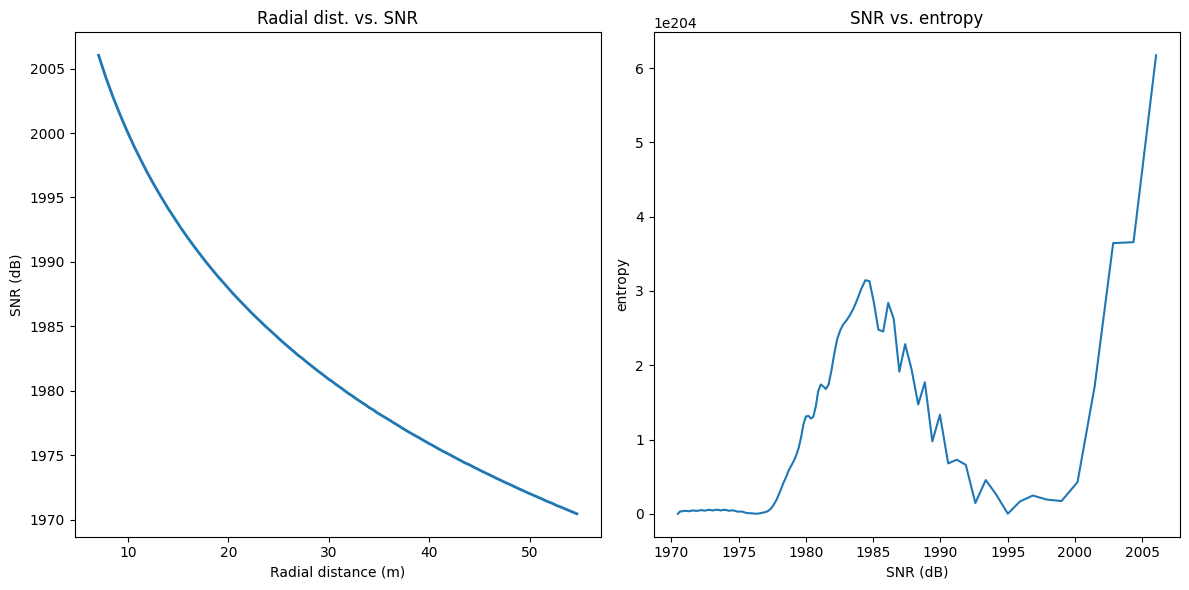

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


#axs[0].plot(np.linspace(0, max_range, Ns), np.abs(data_fourier.T), lw=2)
axs[0].plot(radial_distances, sim_data_snrs, lw=2)
axs[1].plot(sim_data_snrs, term_3_data)

#axs[0].set_xlim([0, 10])
axs[0].set_title('Radial dist. vs. SNR')
axs[1].set_title('SNR vs. entropy')

axs[0].set_xlabel('Radial distance (m)')
axs[1].set_xlabel('SNR (dB)')

axs[0].set_ylabel('SNR (dB)')
axs[1].set_ylabel('entropy')


#axs[1].set_xlim([0, 10])
#axs[1].set_title('Generated S Signal')

plt.tight_layout()
plt.show()

In [29]:
fram = 2

sim_data_all_virtual = sim_data[fram,:,:,0,:]
sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

# Energy normalization
sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[k:k+256, 0]) for k in range(0, len(sim_data_all_virtual), 256)])

data_fourier_energy = data_fourier.conj().T @ data_fourier

#data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

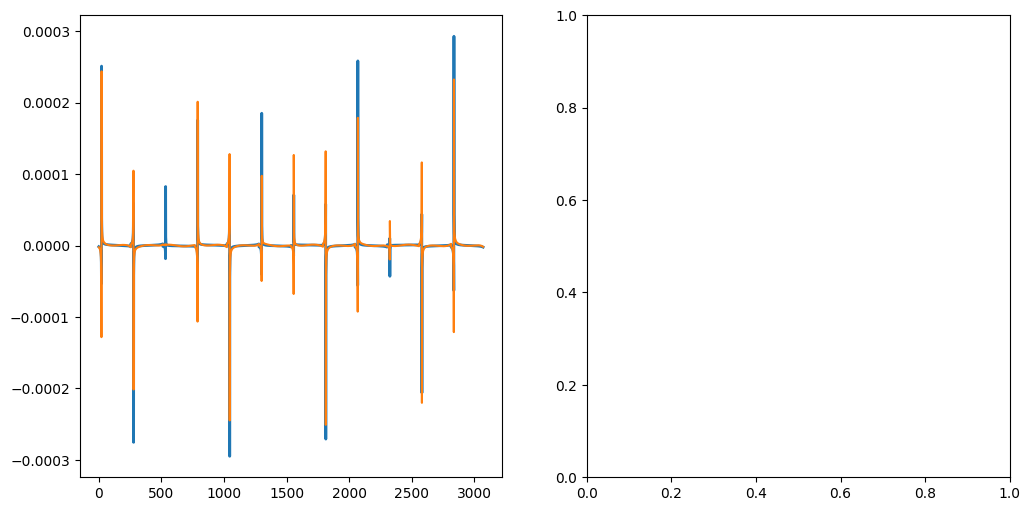

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


#axs[0].plot(np.linspace(0, max_range, Ns), np.abs(data_fourier.T), lw=2)
axs[0].plot(np.real(data_fourier), lw=2)
axs[0].plot(np.real(generate_S_signal(target_ground_truth[0][fram], target_ground_truth[1][fram])))

#axs[0].set_xlim([0, 200])
#axs[1].set_xlim([0, 200])

AttributeError: 'Simulation' object has no attribute '_Simulation__tracking_algorithm'

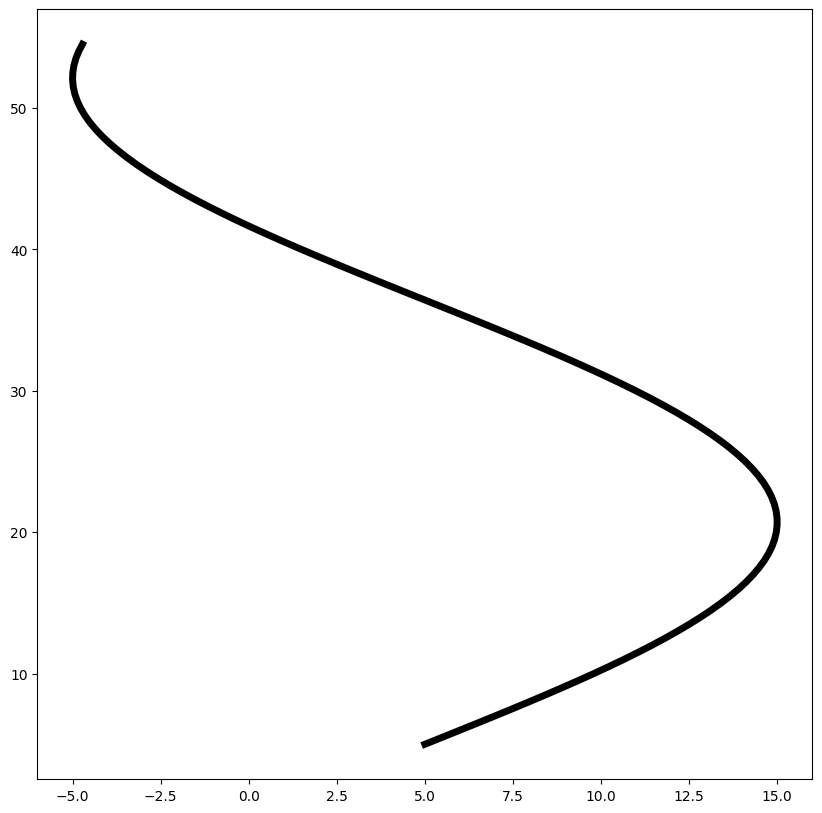

In [58]:
simulation_data.plot()